In [8]:
import os
from PIL import Image
import torch
from torchvision.transforms import functional as F
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
from dataset import LabeledDataset
import transforms as T
import utils


plt.style.use('seaborn')
sns.set(style='whitegrid')

class UnlabeledDataset(torch.utils.data.Dataset):
    def __init__(self, root, transform):
        r"""
        Args:
            root: Location of the dataset folder, usually it is /unlabeled
            transform: the transform you want to applied to the images.
        """
        self.transform = transform
        self.image_dir = root
        self.filelist = os.listdir(self.image_dir)
        problem_img = ['15460.PNG','151438.PNG', '158432.PNG']
        for p in problem_img:
            if p in self.filelist:
                self.filelist.remove(p)
        self.num_images = len(self.filelist)

    def __len__(self):
        return self.num_images

    def __getitem__(self, idx):
        # the idx of unlabeled image is not consecutive
        with open(os.path.join(self.image_dir, self.filelist[idx]), 'rb') as f:
            try:
                img = Image.open(f).convert('RGB')
            except OSError:
                print(self.filelist[idx],'caused error')
        return F.to_tensor(img)


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [9]:
    
unlabeled_data = UnlabeledDataset(root = '../../data/unlabeled_data', transform = None)
data_loader = torch.utils.data.DataLoader(unlabeled_data, batch_size=1,  num_workers=0)

unlabled_mean = []
unlabled_std = []
nb_samples = 0.
for data in data_loader:
    #data: batch x 3 x 244 x 244// not using the collate fn by  prof
    data.to(device=device)
    batch_samples = data.size(0)
    data = data.view(batch_samples, data.size(1), -1)
    unlabled_mean.append(data.mean(2).sum(0))
    unlabled_std.append(data.std(2).sum(0))
    nb_samples += batch_samples
    if nb_samples % 50000 == 0:
        print(nb_samples,'samples succeeded!')


50000.0 samples succeeded!
100000.0 samples succeeded!
150000.0 samples succeeded!
200000.0 samples succeeded!
250000.0 samples succeeded!
300000.0 samples succeeded!
350000.0 samples succeeded!
400000.0 samples succeeded!
450000.0 samples succeeded!
500000.0 samples succeeded!


In [27]:
new_mean = []
for i in unlabled_mean:
    new_mean.append(torch.div(i, 1).detach().numpy())
new_mean = np.array(new_mean)
new_var = []
for i in unlabled_std:
    new_var.append(torch.div(i, 1).detach().numpy())
new_var = np.array(new_var)

In [11]:
import os
from PIL import Image
import torch
from torchvision.transforms import functional as F 
from dataset import LabeledDataset
import transforms as T
import utils

def get_transform(train):
    transforms = []
    transforms.append(T.ToTensor())

    return T.Compose(transforms)
    

In [12]:
train_dataset = LabeledDataset(root='../../data/labeled', split="training", transforms=get_transform(train=True))
val_dataset = LabeledDataset(root='../../data/labeled', split="validation", transforms=get_transform(train=True))
dataset = torch.utils.data.ConcatDataset([train_dataset, val_dataset])
data_loader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True, num_workers=2, collate_fn=utils.collate_fn)
print(f'Dataset size: {len(dataset)}')

labled_mean = []
labled_std = []
nb_samples = 0.
for data, _ in data_loader:
    #data: batch x 3 x 244 x 244// not using the collate fn by prof
    data = data[0]
    batch_samples = 1
    data = data.view(batch_samples, data.size(0), -1)
    labled_mean.append(data.mean(2).sum(0))
    labled_std.append(data.std(2).sum(0))
    nb_samples += batch_samples
    if nb_samples % 1000 == 0:
        print(nb_samples,'samples succeeded!')

Dataset size: 50000
1000.0 samples succeeded!
2000.0 samples succeeded!
3000.0 samples succeeded!
4000.0 samples succeeded!
5000.0 samples succeeded!
6000.0 samples succeeded!
7000.0 samples succeeded!
8000.0 samples succeeded!
9000.0 samples succeeded!
10000.0 samples succeeded!
11000.0 samples succeeded!
12000.0 samples succeeded!
13000.0 samples succeeded!
14000.0 samples succeeded!
15000.0 samples succeeded!
16000.0 samples succeeded!
17000.0 samples succeeded!
18000.0 samples succeeded!
19000.0 samples succeeded!
20000.0 samples succeeded!
21000.0 samples succeeded!
22000.0 samples succeeded!
23000.0 samples succeeded!
24000.0 samples succeeded!
25000.0 samples succeeded!
26000.0 samples succeeded!
27000.0 samples succeeded!
28000.0 samples succeeded!
29000.0 samples succeeded!
30000.0 samples succeeded!
31000.0 samples succeeded!
32000.0 samples succeeded!
33000.0 samples succeeded!
34000.0 samples succeeded!
35000.0 samples succeeded!
36000.0 samples succeeded!
37000.0 samples s

In [28]:
new_mean_2 = []
for i in labled_mean:
    new_mean_2.append(torch.div(i, 1).detach().numpy())
new_mean_2 = np.array(new_mean_2)
new_var_2 = []
for i in labled_std:
    new_var_2.append(torch.div(i, 1).detach().numpy())
new_var_2 = np.array(new_var_2)

In [24]:
new_mean

array([0.6925583 , 0.5476396 , 0.65048796, ..., 0.3690423 , 0.09988387,
       0.50235194], dtype=float32)

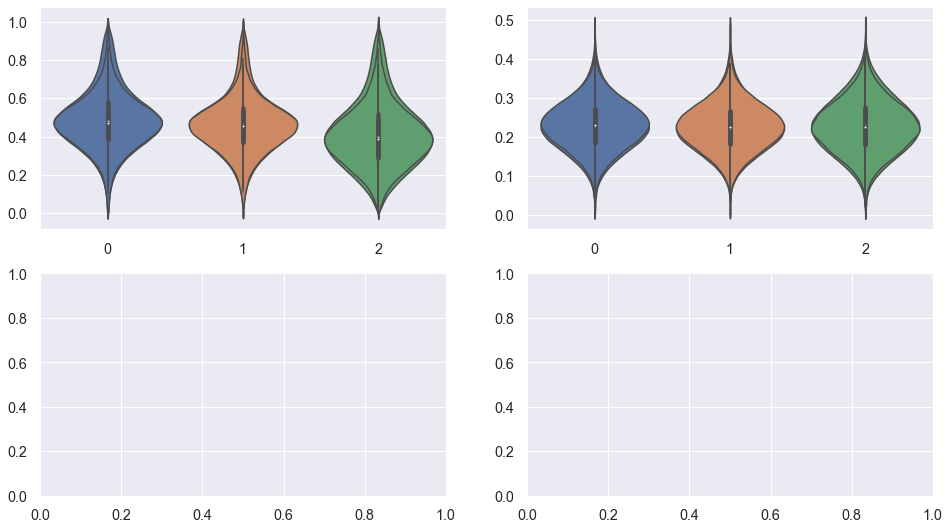

In [33]:
sns.set(font_scale = 1.3)

fig, ((ax1, ax2), (ax3, ax4))= plt.subplots(nrows=2, ncols=2, figsize=(16,9))

sns.violinplot(data=new_mean, ax=ax1, scale='width')
sns.violinplot(data=new_var, ax=ax2, scale='width')
sns.violinplot(data=new_mean_2, ax=ax1, scale='width')
sns.violinplot(data=new_var_2, ax=ax2, scale='width')
plt.savefig('plot3.png')

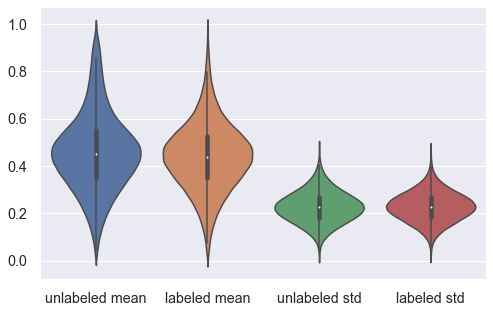

In [36]:
sns.set(font_scale = 1.3)

fig, ax= plt.subplots(nrows=1, ncols=1, figsize=(8,5))

sns.violinplot(data=[new_mean, new_mean_2, new_var, new_var_2], ax=ax, scale='width')
# sns.violinplot(data=[new_var, new_var_2], ax=ax, scale='width')
ax.set_xticklabels(["unlabeled mean", "labeled mean", "unlabeled std", "labeled std"])
plt.savefig('plot1.png')

TypeError: only integer scalar arrays can be converted to a scalar index

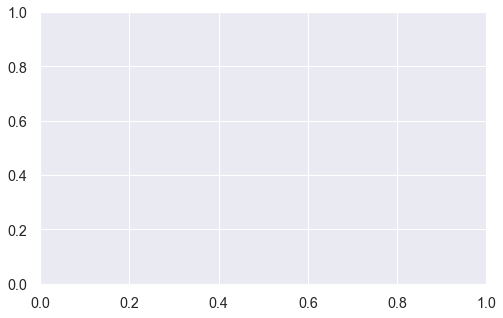

In [44]:
fig,ax= plt.subplots(nrows=1, ncols=1, figsize=(8,5))

sns.boxplot(data=np.concatenate(new_mean, new_mean_2), ax=ax)
# sns.boxplot(data=new_mean_2, ax=ax)
# ax.set_xticklabels(["unlabeled mean", "labeled mean", "unlabeled std", "labeled std"])

In [47]:
np.concatenate((new_mean, new_mean_2),axis=1).shape

ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 0, the array at index 0 has size 511997 and the array at index 1 has size 50000